In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
import tensorflow_model_optimization as tfmot

'2.4.0'

In [92]:
plt.rcParams["figure.figsize"] = (20,20)

In [3]:
with np.load('mnist.npz') as f:
    x_train, y_train = f['x_train'], f['y_train']

x_train = x_train/255 # Normalize pixel values to [0,1] and flatten each image to 1D.
y_train = keras.utils.to_categorical(y_train) # One-hot encoding

print('This is how a one-hot encoded 5 looks like')
print(y_train[0])

This is how a one-hot encoded 5 looks like
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [55]:
def create_base_model():
    raw_model = Sequential()
    raw_model.add(Conv2D(input_shape=(28, 28, 1), kernel_size=(16, 16), filters=32, strides=(4, 4), activation='relu', name="conv1"))
    raw_model.add(Conv2D(kernel_size=(3, 3), filters=64, strides=(1, 1), activation='relu', name="conv2"))
    raw_model.add(Flatten())
    raw_model.add(Dense(10, activation='softmax'))
    return raw_model

In [67]:
model = create_base_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 4, 4, 32)          8224      
_________________________________________________________________
conv2 (Conv2D)               (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 29,290
Trainable params: 29,290
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
118/118 [==============================] - 2s 16ms/step - loss: 0.9820 - accuracy: 0.7278
Epoch 2/5
118/118 [==============================] - 2s 15ms/step - loss: 0.3077 - accuracy: 0.9133
Epoch 3/5
118/118 [==============================] - 2s 14ms/step - loss: 0.2049 - accuracy: 0.9405
Epoch 4/5
118/118 [==============================] - 2s 14ms/step - loss: 0.1440 - accuracy: 0.9582
Epoch 5/5
118/118 [==============================] - 2s 14ms/step - loss: 0.1170 - accuracy: 0.9652


Text(0, 0.5, 'Accuracy')

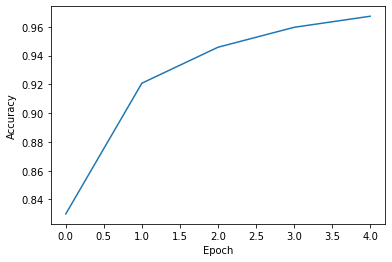

In [68]:
# Fit the model:
model.compile(optimizer='RMSprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
history = model.fit(x_train.reshape(-1,28,28,1), y_train, batch_size=512, epochs=5)
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Model prediction: 9


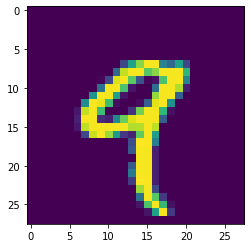

In [69]:
# classify image:
k = 4
image = x_train[k]
y_predict = np.argmax(model.predict(image[None, :,:, None]))

print("Model prediction:", y_predict)
plt.imshow(image.reshape(28, 28))

# Save the model

In [70]:
model.save("mnist.h5")

# Prune the model

In [132]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 512
epochs = 5
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

print("end_step:", end_step)

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
                                                               final_sparsity=0.20,
                                                               begin_step=0,
                                                               end_step=end_step)
}

raw_model = create_base_model()
#raw_model.load_weights(pretrained_weights)

model_pruned = prune_low_magnitude(raw_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_pruned.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#model_for_pruning.summary()

end_step: 530


In [133]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  #tfmot.sparsity.keras.PruningSummaries(log_dir="log")
]

model_pruned.fit(x_train.reshape(-1,28,28,1), y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)


#%tensorboard --logdir={"log"}

Epoch 1/5
106/106 [==============================] - 2s 16ms/step - loss: 1.0188 - accuracy: 0.7054 - val_loss: 0.2907 - val_accuracy: 0.9215
Epoch 2/5
106/106 [==============================] - 2s 15ms/step - loss: 0.3313 - accuracy: 0.9059 - val_loss: 0.2175 - val_accuracy: 0.9392
Epoch 3/5
106/106 [==============================] - 2s 15ms/step - loss: 0.2502 - accuracy: 0.9284 - val_loss: 0.1627 - val_accuracy: 0.9560
Epoch 4/5
106/106 [==============================] - 2s 14ms/step - loss: 0.1876 - accuracy: 0.9450 - val_loss: 0.1324 - val_accuracy: 0.9628
Epoch 5/5
106/106 [==============================] - 1s 14ms/step - loss: 0.1500 - accuracy: 0.9563 - val_loss: 0.1216 - val_accuracy: 0.9657


In [134]:
model_pruned_export = tfmot.sparsity.keras.strip_pruning(model_pruned)

In [135]:
total_weights = 0
total_weights_0 = 0

for idx, layer in enumerate(model_pruned.layers):
    weights_layer = 0
    weights_0 = 0
    
    if len(layer.weights) == 0:
        continue

    for weight in np.nditer(layer.weights):
        if type(weight) != tuple:
            continue

        weights_layer += 1
        if weight[0] == 0:
            weights_0 += 1

    print("Layer: ", idx, "Zero weights:", weights_0, "/", weights_layer)
    total_weights += weights_layer
    total_weights_0 += weights_0

print("Total 0-weights:", total_weights_0, "/", total_weights, " => ", (total_weights_0 / total_weights) * 100, "%")

Layer:  0 Zero weights: 1639 / 8192
Layer:  1 Zero weights: 3687 / 18432
Layer:  2 Zero weights: 0 / 0
Layer:  3 Zero weights: 512 / 2560
Total 0-weights: 5838 / 29184  =>  20.004111842105264 %


# Quantize the model

In [71]:
def representative_dataset_gen():
  for i in range(100):
    yield [x_train[i].reshape(-1,28,28,1).astype(np.float32)]

#converter = tf.lite.TFLiteConverter.from_keras_model(model_pruned_export)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# NOTE: The current version of TensorFlow appears to break the model when using optimizations
#    You can try uncommenting the following if you would like to generate a smaller size .tflite model
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/vb/mchghtt9519g6bs7gqw029vm0000gn/T/tmpt51xl41j/assets


INFO:tensorflow:Assets written to: /var/folders/vb/mchghtt9519g6bs7gqw029vm0000gn/T/tmpt51xl41j/assets
2021-12-27 19:42:47.575048: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-12-27 19:42:47.575281: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-12-27 19:42:47.576174: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2021-12-27 19:42:47.761839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2021-12-27 19:42:47.761856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


35936

# Test the tflite model

In [ ]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_quantization_parameters = input_details[0]['quantization_parameters']
output_quantization_parameters = output_details[0]['quantization_parameters']

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])
print("quantization scale:", input_quantization_parameters['scales'])
print("quantization zero point:", input_quantization_parameters['zero_points'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])
print("quantization scale:", output_quantization_parameters['scales'])
print("quantization zero point:", output_quantization_parameters['zero_points'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

### Accuracy

In [ ]:
def predict(interpreter, input_data):
    interpreter.set_tensor(input_details[0]["index"], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])
    return output_data


def measure_accuracy(interpreter, samples = len(x_train)):
    output_data = []

    for idx, sample in enumerate(x_train[:samples]):
        input_data = np.array(sample, dtype=np.float32)
        input_data = np.expand_dims(input_data, axis=0)
        input_data = np.expand_dims(input_data, axis=3)
        output_data.append(predict(interpreter, input_data))

    a = [np.argmax(y, axis=None, out=None) for y in output_data]
    b = [np.argmax(y, axis=None, out=None) for y in y_train[:samples]]

    accuracy = (np.array(a) == np.array(b)).mean()
    print("TFLite Accuracy:", accuracy)

In [ ]:
measure_accuracy(interpreter, 1000)

# Save .TFLite as C Array

In [ ]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "alignas(8) const unsigned char g_model[] = {\n  " + ascii_bytes + "\n};\nconst unsigned int g_model_len = " + str(len(tflite_binary)) + ";"
open("model.h", "w").write(c_file)

# Pruning with kerassurgeon

In [8]:
%load_ext autoreload
%autoreload 2

In [24]:
import kerassurgeon
from kerassurgeon import operations
from kerassurgeon import identify

In [136]:
for layer in model_pruned_export.layers:
    print(layer.name)

conv1
conv2
flatten_6
dense_6


In [137]:
layer = model_pruned_export.get_layer("conv2")
apoz = kerassurgeon.identify.get_apoz(model_pruned_export, layer, x_train)

In [138]:
high_apoz_channels = kerassurgeon.identify.high_apoz(apoz, "both")
high_apoz_channels

array([24, 25, 30, 34, 54, 61])

In [139]:
model_pruned_export = kerassurgeon.operations.delete_channels(model_pruned_export, layer, high_apoz_channels)

Deleting 6/64 channels from layer: conv2


In [140]:
model_pruned_export.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 4, 4, 32)          8224      
_________________________________________________________________
conv2 (Conv2D)               (None, 2, 2, 58)          16762     
_________________________________________________________________
flatten_6 (Flatten)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2330      
Total params: 27,316
Trainable params: 27,316
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
118/118 [==============================] - 2s 14ms/step - loss: 0.1193 - accuracy: 0.9650
Epoch 2/5
118/118 [==============================] - 2s 14ms/step - loss: 0.0873 - accuracy: 0.9744
Epoch 3/5
118/118 [==============================] - 2s 14ms/step - loss: 0.0737 - accuracy: 0.9783
Epoch 4/5
118/118 [==============================] - 2s 14ms/step - loss: 0.0637 - accuracy: 0.9804
Epoch 5/5
118/118 [==============================] - 2s 14ms/step - loss: 0.0579 - accuracy: 0.9825


Text(0, 0.5, 'Accuracy')

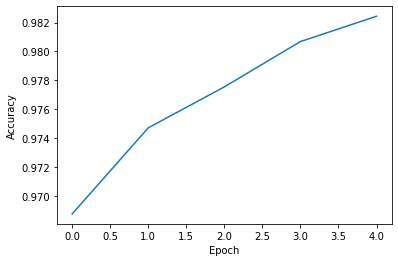

In [64]:
# Fit the model:
model.compile(optimizer='RMSprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
history = model.fit(x_train.reshape(-1,28,28,1), y_train, batch_size=512, epochs=5)
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [74]:
from kerassurgeon import utils as k_utils

In [78]:
k_utils.find_nodes_in_model(model, model.get_layer("conv2"))

[0]

conv2 (3, 3, 32, 53)
58


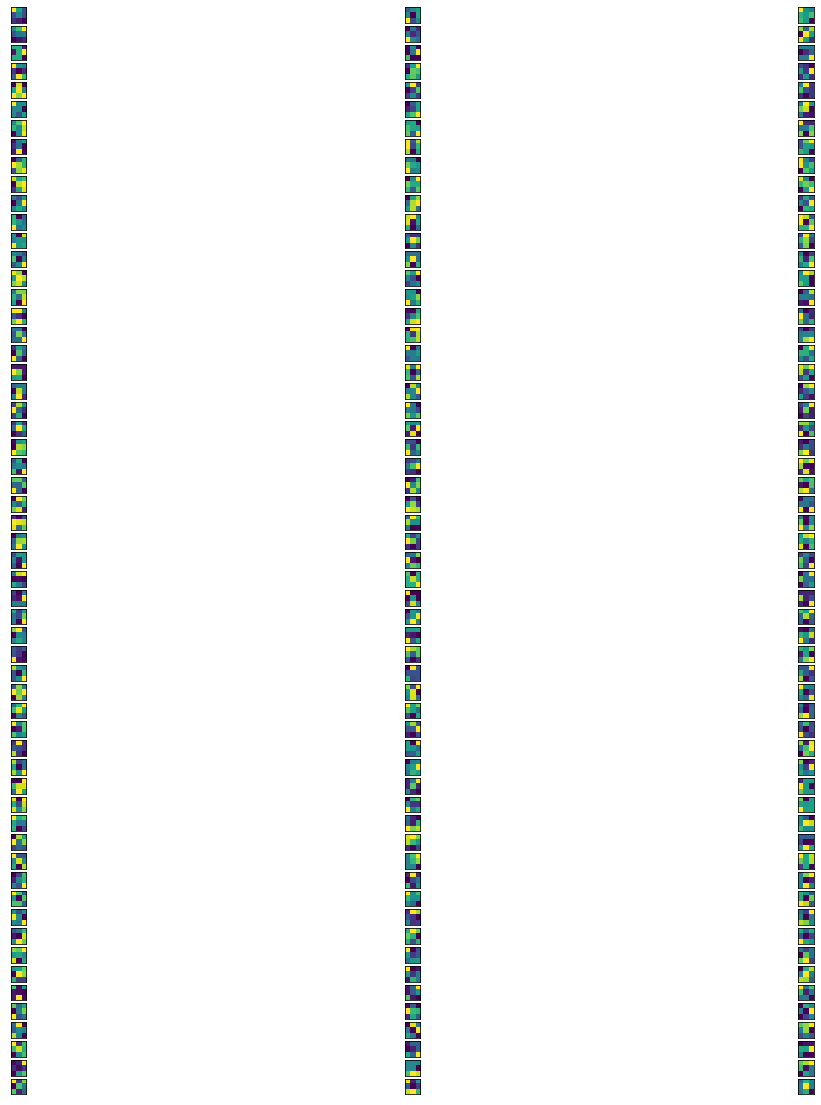

In [141]:
#Iterate thru all the layers of the model
for layer in model_pruned_export.layers:
    if 'conv2' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()